# Segmenting a Brain MRI (Magnetic Resonance Image)

In [1]:
from h5py import File as h5FileReader
import numpy as np
import matplotlib.pyplot as plt

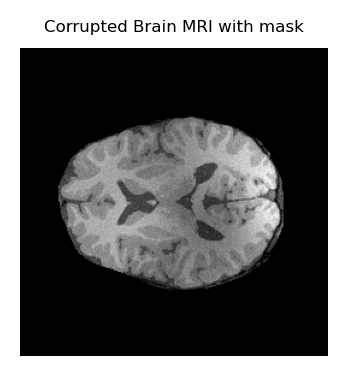

In [2]:
with h5FileReader('data/SegmentBrain.mat') as f_corrupted:
    brainMRI = np.array(f_corrupted['imageData'])
    brainMask = np.array(f_corrupted['imageMask'])
    brainMRI *= brainMask

plt.figure(figsize=(4, 2), dpi=200)
plt.imshow(brainMRI, cmap='gray')
plt.title('Corrupted Brain MRI with mask', fontsize=6)
plt.axis('off')
plt.show()

In [3]:
np.random.seed(0)

def kmeans_plus_plus_init(image, clusters):
    data = image[brainMask == 1].flatten()
    centroids = [data[np.random.choice(len(data))]]
    
    for _ in range(1, clusters):
        dists = np.min((data[:, None] - np.array(centroids)[None, :])**2, axis=1)
        probs = dists / np.sum(dists)
        centroids.append(data[np.random.choice(len(data), p=probs)])
    
    return np.array(centroids)

def initialize_fcm_memberships(image, centroids, q, mask):
    rows, cols = image.shape
    clusters = len(centroids)
    
    distances = np.zeros((rows, cols, clusters))
    epsilon = 1e-10

    for k in range(clusters):
        distances[:, :, k] = (image - centroids[k]) ** 2

    distances = np.fmax(distances, epsilon)
    inv_distances = distances ** (-1 / (q - 1))
    
    U = inv_distances / np.sum(inv_distances, axis=2, keepdims=True)
    return U * mask[:, :, None]

def modified_fcm(image, mask, weights, clusters, q, epochs):
    rows, cols = image.shape
    centroids_ini = kmeans_plus_plus_init(image, clusters)
    centroids = centroids_ini.copy()
    U_ini = initialize_fcm_memberships(image, centroids, q, mask)
    U = U_ini.copy()

    biases = np.ones_like(image)
    epsilon = 1e-10  
    J = np.zeros(epochs)  

    for epoch in range(epochs):
        # Update centroids
        for k in range(clusters):
            num = np.sum((U[:, :, k] ** q) * biases * image)
            denom = np.sum((U[:, :, k] ** q) * (biases ** 2))
            centroids[k] = num / (denom + epsilon)

        # Update bias field
        num = np.sum(U ** q * centroids[None, None, :], axis=2)
        denom = np.sum(U ** q * centroids[None, None, :] ** 2, axis=2)
        biases = image * num / (denom + epsilon) * mask  # Apply mask

        # Update memberships
        distances = np.zeros((rows, cols, clusters))
        for k in range(clusters):
            distances[:, :, k] = ((image - biases * centroids[k]) ** 2) / weights

        distances = np.fmax(distances, epsilon)
        inv_distances = distances ** (-1 / (q - 1))
        U = inv_distances / np.sum(inv_distances, axis=2, keepdims=True)
        U *= mask[:, :, None]

        J[epoch] = np.sum(U ** q * distances)

    plt.figure(figsize=(4, 2), dpi=200)
    plt.rcParams.update({'font.size': 6})
    plt.plot(J)
    plt.xlabel("Epoch")
    plt.ylabel("Objective Function J")
    plt.title("Convergence of FCM")
    plt.show()

    return centroids, U, biases, centroids_ini, U_ini

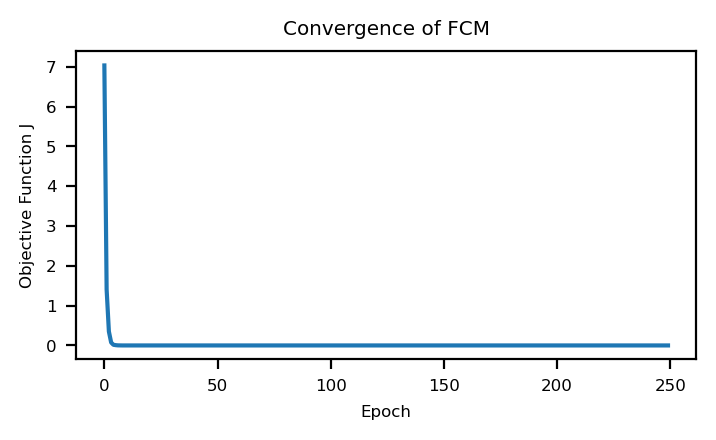

In [4]:
clusters = 3
q = 2  # The chosen value of q
epochs = 250
weights = np.ones_like(brainMRI)
centroids, U, biases, centroids_ini, U_ini = modified_fcm(brainMRI, brainMask, weights, clusters, q, epochs)

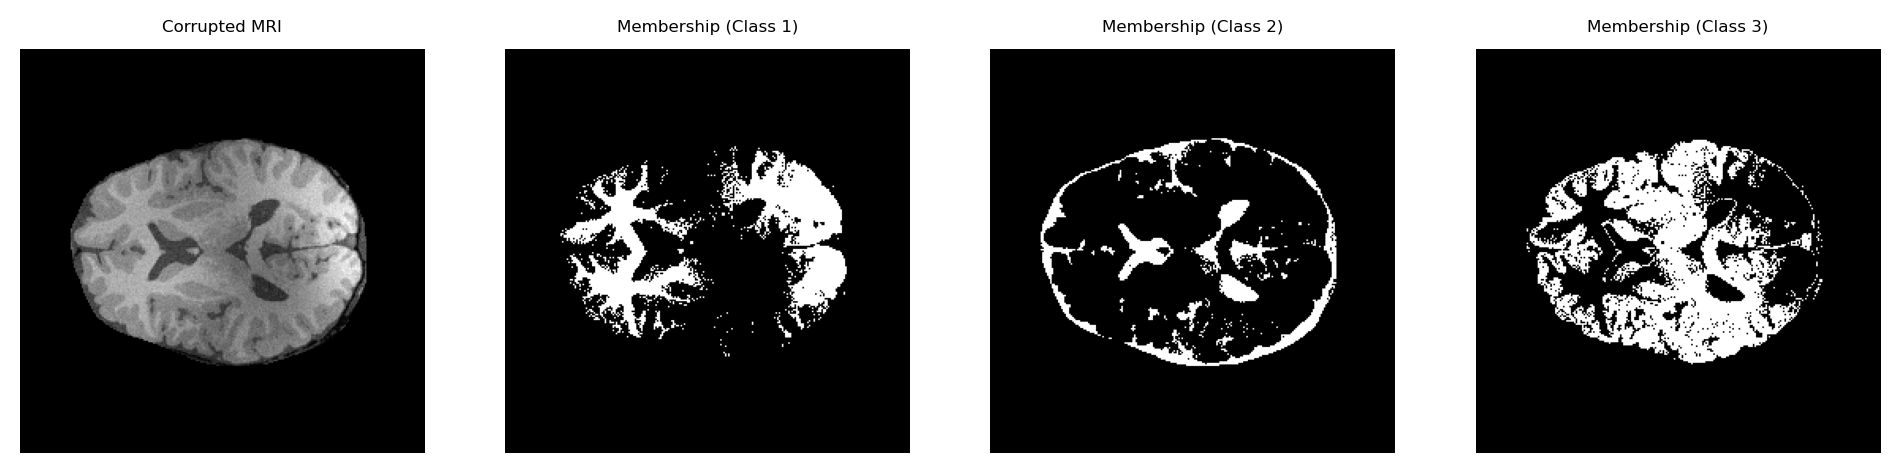

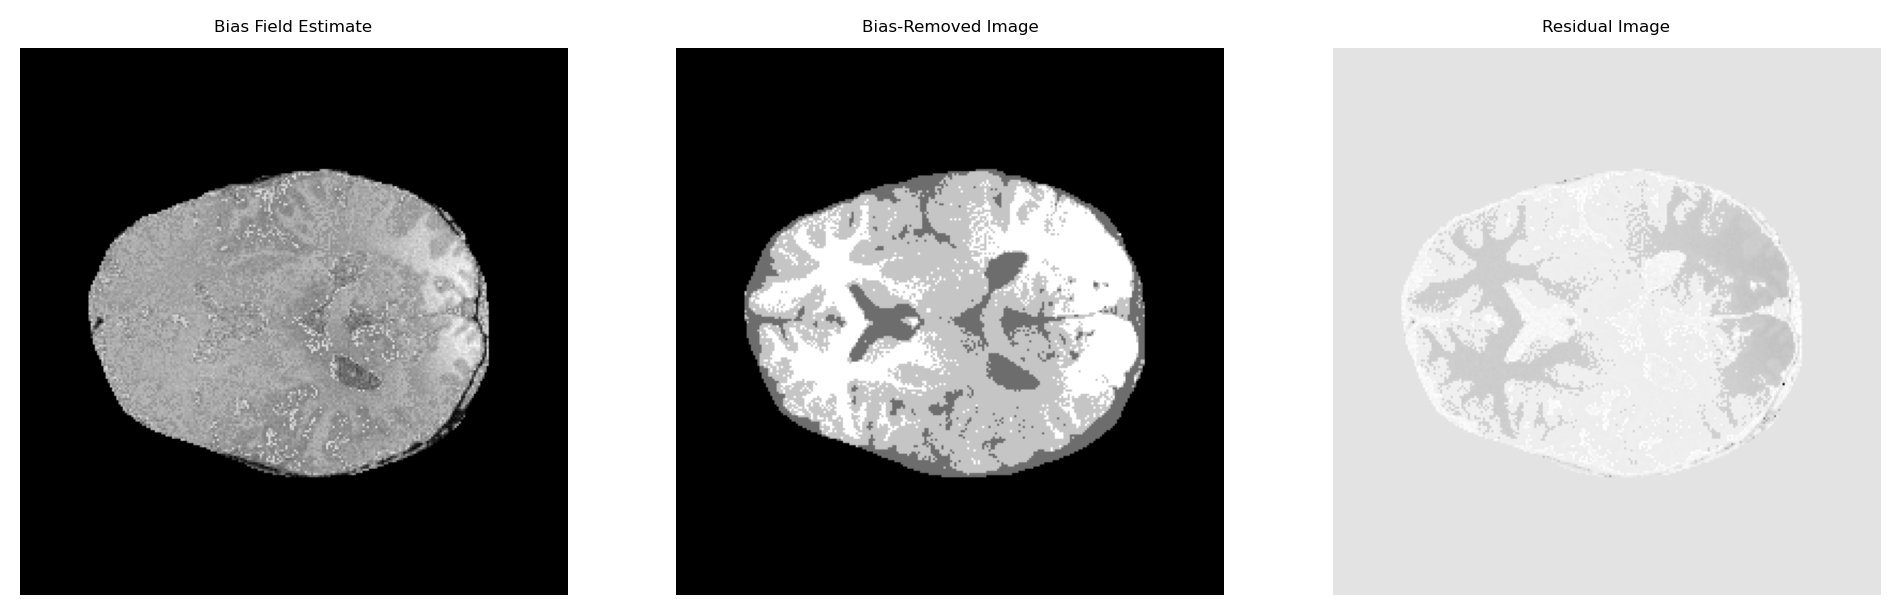

In [5]:
bias_removed_image = np.sum(U * centroids[None, None, :], axis=2) * brainMask
residual_image = (brainMRI - bias_removed_image * biases) * brainMask

fig, axes = plt.subplots(1, 4, figsize=(12, 4), dpi=200)

axes[0].imshow(brainMRI, cmap='gray')
axes[0].set_title('Corrupted MRI', fontsize=6)
axes[0].axis('off')

for i in range(clusters):
    axes[i + 1].imshow(U[:, :, i] * brainMask, cmap='gray')
    axes[i + 1].set_title(f'Membership (Class {i+1})', fontsize=6)
    axes[i + 1].axis('off')

plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=200)

axes[0].imshow(biases, cmap='gray')
axes[0].set_title('Bias Field Estimate', fontsize=6)
axes[0].axis('off')

axes[1].imshow(bias_removed_image, cmap='gray')
axes[1].set_title('Bias-Removed Image', fontsize=6)
axes[1].axis('off')

axes[2].imshow(residual_image, cmap='gray')
axes[2].set_title('Residual Image', fontsize=6)
axes[2].axis('off')

plt.show()

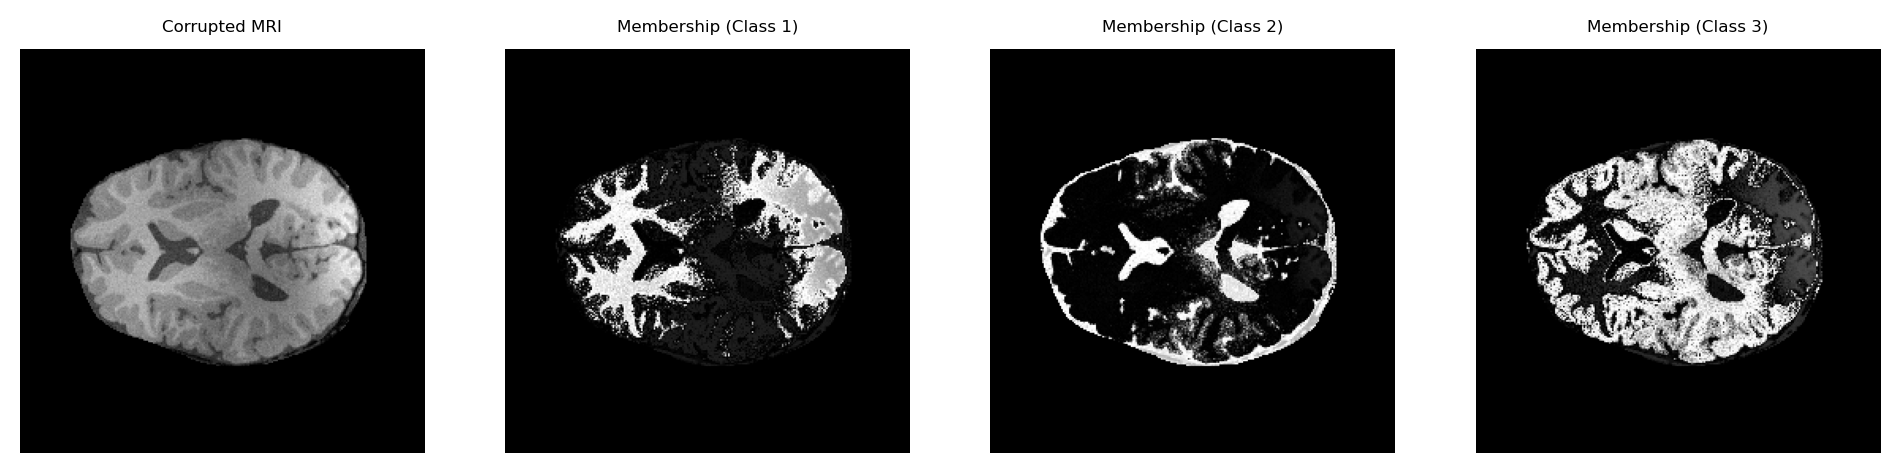

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4), dpi=200)

axes[0].imshow(brainMRI, cmap='gray')
axes[0].set_title('Corrupted MRI', fontsize=6)
axes[0].axis('off')

for i in range(clusters):
    axes[i + 1].imshow(U_ini[:, :, i] * brainMask, cmap='gray')
    axes[i + 1].set_title(f'Membership (Class {i+1})', fontsize=6)
    axes[i + 1].axis('off')

plt.show()

Used the normal FCM algorithm for initializing the memberships.

In [7]:
centroids_ini

array([0.580275 , 0.2508946, 0.4717287], dtype=float32)

Used the kmeans++ algorithm for initializing the centroids

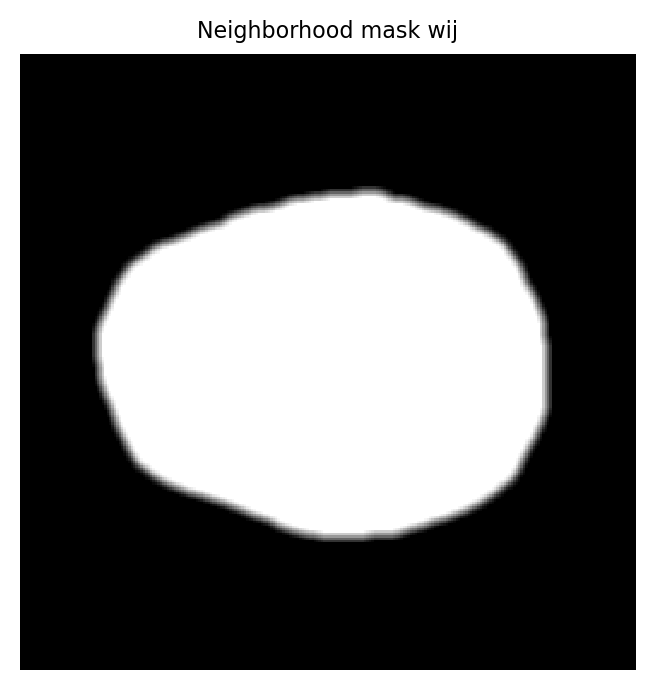

In [8]:
# Compute the neighborhood mask wij using a 5x5 kernel (summing mask values in a 5x5 neighborhood)
kernel_size = 5
pad = kernel_size // 2
padded_mask = np.pad(brainMask, pad, mode='constant')
wij = np.empty_like(brainMask)

rows, cols = brainMask.shape
for i in range(rows):
    for j in range(cols):
        wij[i, j] = padded_mask[i:i+kernel_size, j:j+kernel_size].sum()

# Plot the neighborhood mask with nearest neighbor interpolation to avoid any blurring
plt.figure(figsize=(4, 4), dpi=200)
plt.imshow(wij, cmap='gray', interpolation='nearest')
plt.title("Neighborhood mask wij", fontsize=8)
plt.axis('off')
plt.show()

In [9]:
# The optimal estimates for the class means
centroids

array([0.59483445, 0.25491074, 0.45975235], dtype=float32)

The reason is similar to the one discussed in dict. learning, we optimize `bc`, but if we don't have a restriction on one of them, on of them may shoot up. SO, we restrict one.